Challenge is a Multioutput Classifier where one needs to predict multiple target variables at once i.e. for the various targets, they also need to prediction on whether they are present 
- whether there is a building or not
- whether there is cropland or not, 
- whether wcover is more than 60%

buildings values ['No' 'Yes']
cropland values ['No' 'Yes']
wcover values ['>60%' '<30%' '>30%']

In [1]:
!pip install lightgbm

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report



In [3]:
# data path
# !cp -r /kaggle/input/test-data /kaggle/working/
# BASE_PATH = '/kaggle/working/test-data'

#working folder
BASE_PATH = '/Users/njoki/Desktop/Stuff/Me/Interviews/Amini/Task1'


In [4]:
#datasets
train_ = BASE_PATH+'/train_land_cover_assignment.csv'
test_ = BASE_PATH+'/test_land_cover_assignment.csv'
metadata_ = BASE_PATH+'/CIV_grids.csv'
submission_ = BASE_PATH+'/sample_submission_assignment.csv'


In [5]:
#reading csv data files

def read_csv_file(file_name):
    readfile = pd.read_csv(file_name)
    return readfile

train_ds = read_csv_file(train_)
metadata = read_csv_file(metadata_)
test_ds = read_csv_file(test_)
sub_file = read_csv_file(submission_)

## Exploratory Data Analysis
- Understanding the data through column available and the metadata

In [6]:
train_ds.head()

,subid,lat,lon,building,cropland,wcover,bcount,x,y,bd20,...,mlon,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,1548937,7.387687,-4.780390,No,No,>60%,0.0,-2.714375e+06,321874.969864,1.4900,...,-4.781606,5052.299805,853.451416,6.100,0.717054,0.008259,0.729217,66.75,12.25,8.079082
1,1548936,8.690266,-5.770243,No,Yes,<30%,0.0,-2.812625e+06,474124.973063,1.2925,...,-5.771476,5316.700195,933.074402,5.575,0.717198,0.007242,1.086981,51.50,14.25,9.549431
2,1548935,8.518763,-2.808147,No,Yes,<30%,0.0,-2.495125e+06,440374.986977,1.3050,...,-2.809363,4519.700195,1186.817627,5.850,0.717171,0.006744,1.159993,47.00,14.50,10.523131
3,1548934,8.637725,-3.048867,No,No,<30%,0.0,-2.520375e+06,454875.008083,1.3275,...,-3.050085,3439.800049,910.979309,5.950,0.718244,0.007917,2.471163,62.75,12.75,9.305363
4,1548933,7.993474,-6.044227,No,No,<30%,0.0,-2.846625e+06,396624.944149,1.4200,...,-6.045455,5226.899902,802.602661,5.800,0.716653,0.007022,0.259416,55.00,13.25,15.732859


In [7]:
metadata.shape


(40, 4)

In [8]:
metadata.head(40)

,Variable name,Description,Data source,Original data link
0,bd20,"Topsoil bulk density (Mg/m^3, soil fines)",SoilGrids,https://soilgrids.org
1,bio1,"Mean annual temperature (deg. C * 10, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
2,bio7,"Mean annual temperature range (deg. C * 10, 19...",Chelsa,http://chelsa-climate.org/downloads/
3,bio12,"Mean annual precipitation (mm/yr, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
4,bio15,"Mean rainfall seasonality (CV, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
5,cec20,Predicted topsoil cation exchange capacity (cm...,SoilGrids,https://soilgrids.org
6,dipa,Distance to internationally protected areas (km),ProtectedPlanet,http://www.protectedplanet.net/
7,dni,Direct normal irradiation (kWhr/m^2),GlobalSolarAtlas,https://globalsolaratlas.info/download/cote-d-...
8,dnpa,Distance to nationally protected areas (km),ProtectedPlanet,http://www.protectedplanet.net/
9,dor1,Distance to major road (km),Geofabrik,https://www.geofabrik.de/data/download.html


In [9]:
metadata_features = metadata['Variable name'].values.tolist()
metadata_features

['bd20',
 'bio1',
 'bio7',
 'bio12',
 'bio15',
 'cec20',
 'dipa',
 'dni',
 'dnpa',
 'dor1',
 'dor2',
 'dows',
 'fpara',
 'fpars',
 'lcc8',
 'lcc9',
 'lcc10',
 'lcc11',
 'lcc12',
 'lcc13',
 'lcc14',
 'lcc21',
 'lstd',
 'lstn',
 'mb1',
 'mb2',
 'mb3',
 'mb7',
 'mdem',
 'mlat',
 'mlon',
 'nppa',
 'npps',
 'ph20',
 'sirm',
 'sire',
 'slope',
 'snd20',
 'soc20',
 'tim']

In [10]:
train_feat = list(train_ds.columns)
test_feat = list(test_ds.columns)

train_feat

['subid',
 'lat',
 'lon',
 'building',
 'cropland',
 'wcover',
 'bcount',
 'x',
 'y',
 'bd20',
 'bio1',
 'bio12',
 'bio7',
 'bio15',
 'cec20',
 'dipa',
 'dni',
 'dnlt',
 'dnpa',
 'dor1',
 'dor2',
 'fpara',
 'fpars',
 'lcc10',
 'lcc11',
 'lcc12',
 'lcc13',
 'lcc14',
 'lcc21',
 'lcc8',
 'lcc9',
 'lstd',
 'lstn',
 'mb1',
 'mb2',
 'mb3',
 'mb7',
 'mdem',
 'mlat',
 'mlon',
 'nppm',
 'npps',
 'ph20',
 'sirm',
 'sirs',
 'slope',
 'snd20',
 'soc20',
 'tim']

In [11]:
pred = []
for name in train_feat:
    if name not in test_feat:
        pred.append(name)
print(pred)

['building', 'cropland', 'wcover']


In [12]:
unknowns_feat = []
for name in train_feat:
    if name not in metadata_features:
        unknowns_feat.append(name)
print(unknowns_feat)

['subid', 'lat', 'lon', 'building', 'cropland', 'wcover', 'bcount', 'x', 'y', 'dnlt', 'nppm', 'sirs']


Opting to drop columns that are repeated and not described in metadata i.e. 
- lat, lon, x and y as they are location attributes which are available from mlat and mlon
- subid which are the identifiers thus not part of the training features
- building, cropland,wcover as they are the targets being predicted
- bcount- building count
- dnlt, nppm, sirs- unknowns

In [13]:
unknowns_feat = [x for x in unknowns_feat if x not in pred]
print(unknowns_feat)

['subid', 'lat', 'lon', 'bcount', 'x', 'y', 'dnlt', 'nppm', 'sirs']


In [14]:
unknowns_feat.remove('subid')
unknowns_feat

['lat', 'lon', 'bcount', 'x', 'y', 'dnlt', 'nppm', 'sirs']

In [15]:
#dropping some of the unknown features

train_ds.drop(columns=unknowns_feat, inplace=True)
test_ds.drop(columns=unknowns_feat, inplace=True)

In [16]:
print(f'training data with dropped columns{train_ds.shape}')

training data with dropped columns(15856, 41)


In [17]:
train_ds.head()

,subid,building,cropland,wcover,bd20,bio1,bio12,bio7,bio15,cec20,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
0,1548937,No,No,>60%,1.4900,262,1006,58,128,9.75,...,199,7.388742,-4.781606,853.451416,6.100,0.717054,0.729217,66.75,12.25,8.079082
1,1548936,No,Yes,<30%,1.2925,257,1118,70,162,7.50,...,362,8.691314,-5.771476,933.074402,5.575,0.717198,1.086981,51.50,14.25,9.549431
2,1548935,No,Yes,<30%,1.3050,265,930,66,154,8.50,...,288,8.519824,-2.809363,1186.817627,5.850,0.717171,1.159993,47.00,14.50,10.523131
3,1548934,No,No,<30%,1.3275,263,875,67,156,8.75,...,320,8.638784,-3.050085,910.979309,5.950,0.718244,2.471163,62.75,12.75,9.305363
4,1548933,No,No,<30%,1.4200,260,1073,60,146,9.00,...,265,7.994523,-6.045455,802.602661,5.800,0.716653,0.259416,55.00,13.25,15.732859


In [18]:
for name in metadata_features:
    if name not in train_feat:
        print(name)

dows
nppa
sire


#### Understanding the data size, data formats 
Reference
1. https://www.w3schools.com/python/pandas/ref_df_describe.asp
2. https://medium.com/@mahnoorsalman96/checking-for-missing-values-for-machine-learning-bb4c263a6555#:~:text=Check%20for%20missing%20data%3A%20Pandas,identify%20columns%20with%20missing%20data.

In [19]:
print(train_ds.shape)
print(test_ds.shape)

(15856, 41)
(35, 38)


In [20]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15856 entries, 0 to 15855
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subid     15856 non-null  int64  
 1   building  15856 non-null  object 
 2   cropland  15856 non-null  object 
 3   wcover    15856 non-null  object 
 4   bd20      15811 non-null  float64
 5   bio1      15856 non-null  int64  
 6   bio12     15856 non-null  int64  
 7   bio7      15856 non-null  int64  
 8   bio15     15856 non-null  int64  
 9   cec20     15811 non-null  float64
 10  dipa      15856 non-null  float64
 11  dni       15856 non-null  float64
 12  dnpa      15856 non-null  float64
 13  dor1      15856 non-null  float64
 14  dor2      15856 non-null  float64
 15  fpara     15856 non-null  float64
 16  fpars     15856 non-null  float64
 17  lcc10     15856 non-null  int64  
 18  lcc11     15856 non-null  int64  
 19  lcc12     15856 non-null  int64  
 20  lcc13     15856 non-null  in

In [21]:
train_ds.describe()

,subid,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnpa,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
count,1.585600e+04,15811.000000,15856.000000,15856.000000,15856.000000,15856.000000,15811.000000,15856.000000,15856.000000,15856.000000,...,15856.000000,15856.000000,15856.000000,15856.000000,15811.000000,15856.000000,15856.000000,15811.000000,15811.000000,15855.000000
mean,1.540573e+06,1.436390,258.906723,1276.893983,65.909183,132.873171,8.720574,94.636262,1074.583905,9.101898,...,262.721493,7.640908,-5.559110,1008.710241,5.611881,0.713705,1.509903,55.166245,17.002324,10.336672
std,4.805508e+03,0.163676,6.578450,253.890839,13.210307,35.500514,2.354145,58.842910,191.523997,10.246818,...,123.502385,1.476285,1.500330,318.196819,0.344171,0.066204,1.612766,7.287898,5.461648,1.748071
min,1.532219e+06,1.057500,198.000000,802.000000,43.000000,51.000000,4.000000,0.000000,750.223022,0.000000,...,2.000000,4.385137,-8.584408,0.000000,4.600000,0.000000,0.000000,32.000000,5.000000,5.553461
25%,1.536478e+06,1.287500,255.000000,1096.000000,57.000000,104.000000,7.250000,46.384264,918.237976,0.750000,...,184.000000,6.426884,-6.828711,776.075455,5.400000,0.717612,0.773976,49.750000,13.500000,9.067727
50%,1.540446e+06,1.427500,259.000000,1225.000000,62.000000,136.000000,8.250000,93.431458,1025.987061,6.046693,...,259.000000,7.681501,-5.653874,1020.748413,5.650000,0.720148,1.215919,55.500000,16.500000,9.957087
75%,1.544915e+06,1.575000,263.000000,1408.000000,73.000000,164.000000,9.250000,142.287563,1226.144043,13.500000,...,346.000000,8.864384,-4.272185,1231.379150,5.875000,0.721894,1.742046,60.500000,19.500000,11.363164
max,1.548937e+06,1.865000,277.000000,2586.000000,105.000000,195.000000,30.500000,227.000549,1491.316040,64.106354,...,1295.000000,10.703341,-2.516021,3570.271484,6.675000,0.733020,23.151028,76.500000,53.000000,17.559345


### modified training data

In [22]:
# Get the columns with null values
null_columns = train_ds.columns[train_ds.isnull().any()]

# Get the count of non-null entries in each column
non_null_count = train_ds[null_columns].count()

# Get the columns that have null values along with their count of non-null values
null_info = non_null_count[non_null_count < 15856]
print(null_info)


bd20     15811
cec20    15811
lstd     15837
lstn     15837
mb1      15855
mb2      15855
mb3      15855
mb7      15855
ph20     15811
snd20    15811
soc20    15811
tim      15855
dtype: int64


columns having null values
- bd20(15811 rather than 15856)
- cec20 (15811 rather than 15856)
- lstd(15837 rather than 15856)
- lstn (15837 rather than 15856)
- mb1((15855 rather than 15856)
- mb2((15855 rather than 15856)
- mb3((15855 rather than 15856)
- mb7((15855 rather than 15856)
- ph20((15811 rather than 15856)
- snd20((15811 rather than 15856)
- soc20((15811 rather than 15856)
- tim((15855 rather than 15856)

In [23]:
def fillna_wt_median(dataframe, column):
    dataframe = dataframe.copy()
    dataframe[column] = dataframe[column].fillna(dataframe[column].median())
    return dataframe

train_ds_copy = train_ds.copy()  # Copy once to keep modifications

columns_to_fill = ['bd20', 'cec20', 'lstd', 'lstn', 'mb1', 'mb2', 'mb3', 'mb7', 'ph20', 'snd20', 'soc20', 'tim']

for col in columns_to_fill:
    train_ds_copy = fillna_wt_median(train_ds_copy, col)


train_ds_copy.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15856 entries, 0 to 15855
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subid     15856 non-null  int64  
 1   building  15856 non-null  object 
 2   cropland  15856 non-null  object 
 3   wcover    15856 non-null  object 
 4   bd20      15856 non-null  float64
 5   bio1      15856 non-null  int64  
 6   bio12     15856 non-null  int64  
 7   bio7      15856 non-null  int64  
 8   bio15     15856 non-null  int64  
 9   cec20     15856 non-null  float64
 10  dipa      15856 non-null  float64
 11  dni       15856 non-null  float64
 12  dnpa      15856 non-null  float64
 13  dor1      15856 non-null  float64
 14  dor2      15856 non-null  float64
 15  fpara     15856 non-null  float64
 16  fpars     15856 non-null  float64
 17  lcc10     15856 non-null  int64  
 18  lcc11     15856 non-null  int64  
 19  lcc12     15856 non-null  int64  
 20  lcc13     15856 non-null  in

In [24]:
# Get the columns with null values
null_columns = train_ds_copy.columns[train_ds_copy.isnull().any()]

# Get the count of non-null entries in each column
non_null_count = train_ds_copy[null_columns].count()

# Get the columns that have null values along with their count of non-null values
null_info = non_null_count[non_null_count < 15856]
print(null_info)

Series([], dtype: int64)


In [25]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   subid   35 non-null     int64  
 1   bd20    35 non-null     float64
 2   bio1    35 non-null     int64  
 3   bio12   35 non-null     int64  
 4   bio7    35 non-null     int64  
 5   bio15   35 non-null     int64  
 6   cec20   35 non-null     float64
 7   dipa    35 non-null     float64
 8   dni     35 non-null     float64
 9   dnpa    35 non-null     float64
 10  dor1    35 non-null     float64
 11  dor2    35 non-null     float64
 12  fpara   35 non-null     float64
 13  fpars   35 non-null     float64
 14  lcc10   35 non-null     int64  
 15  lcc11   35 non-null     int64  
 16  lcc12   35 non-null     int64  
 17  lcc13   35 non-null     int64  
 18  lcc14   35 non-null     int64  
 19  lcc21   35 non-null     int64  
 20  lcc8    35 non-null     int64  
 21  lcc9    35 non-null     int64  
 22  lstd

test data does not have null values

Checking the values for the model targets

In [26]:
print('buildings values', train_ds_copy['building'].unique())
print('cropland values', train_ds_copy['cropland'].unique())
print('wcover values', train_ds_copy['wcover'].unique())

buildings values ['No' 'Yes']
cropland values ['No' 'Yes']
wcover values ['>60%' '<30%' '>30%']


Encoding the object datatypes into values the model can interpret

In [27]:
train_ds_copy['building'] = train_ds_copy['building'].map({'Yes': 1, 'No': 0})
train_ds_copy['cropland'] = train_ds_copy['cropland'].map({'Yes': 1, 'No': 0})
train_ds_copy['wcover'] = train_ds_copy['wcover'].map({'<30%': 0, '>30%': 1, '>60%': 2})
train_ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15856 entries, 0 to 15855
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subid     15856 non-null  int64  
 1   building  15856 non-null  int64  
 2   cropland  15856 non-null  int64  
 3   wcover    15856 non-null  int64  
 4   bd20      15856 non-null  float64
 5   bio1      15856 non-null  int64  
 6   bio12     15856 non-null  int64  
 7   bio7      15856 non-null  int64  
 8   bio15     15856 non-null  int64  
 9   cec20     15856 non-null  float64
 10  dipa      15856 non-null  float64
 11  dni       15856 non-null  float64
 12  dnpa      15856 non-null  float64
 13  dor1      15856 non-null  float64
 14  dor2      15856 non-null  float64
 15  fpara     15856 non-null  float64
 16  fpars     15856 non-null  float64
 17  lcc10     15856 non-null  int64  
 18  lcc11     15856 non-null  int64  
 19  lcc12     15856 non-null  int64  
 20  lcc13     15856 non-null  in

In [28]:
# creation of correlation matrix
train_corrM = train_ds_copy.corr()
train_corrM

,subid,building,cropland,wcover,bd20,bio1,bio12,bio7,bio15,cec20,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
subid,1.000000,0.026588,0.026538,0.153188,-0.010743,-0.003620,0.014628,0.014019,-0.001876,0.003521,...,0.003399,0.000132,0.000562,-0.008187,-0.001973,-0.015432,0.010977,0.007444,-0.000331,0.007097
building,0.026588,1.000000,0.026760,-0.069007,0.104078,-0.029743,0.065954,-0.064466,-0.113197,-0.014046,...,-0.079094,-0.109856,-0.002593,-0.116051,-0.016417,-0.015308,-0.027819,0.110791,-0.001464,-0.035060
cropland,0.026538,0.026760,1.000000,-0.144115,-0.012974,0.042653,0.088926,0.172282,0.018109,-0.151710,...,-0.018150,0.027417,-0.076830,-0.077345,0.011107,0.003428,-0.106862,-0.057169,-0.152221,0.039884
wcover,0.153188,-0.069007,-0.144115,1.000000,0.288361,-0.249865,0.294028,-0.183723,-0.314310,0.052085,...,-0.160625,-0.322945,-0.077105,-0.023153,-0.382765,0.011490,0.069182,0.049315,0.252131,-0.168084
bd20,-0.010743,0.104078,-0.012974,0.288361,1.000000,-0.051799,0.234602,-0.587670,-0.798107,-0.059389,...,-0.751264,-0.780784,0.196680,-0.212233,-0.381654,0.028942,-0.144253,0.512982,0.023639,-0.050220
bio1,-0.003620,-0.029743,0.042653,-0.249865,-0.051799,1.000000,-0.596149,0.308519,0.300532,-0.304066,...,-0.294471,0.383129,0.598898,0.300951,0.539026,-0.064808,-0.374335,0.125812,-0.688554,0.185308
bio12,0.014628,0.065954,0.088926,0.294028,0.234602,-0.596149,1.000000,-0.098568,-0.519833,0.139509,...,-0.132004,-0.522565,-0.457022,-0.279396,-0.695767,-0.020766,0.157543,0.016143,0.440538,-0.127181
bio7,0.014019,-0.064466,0.172282,-0.183723,-0.587670,0.308519,-0.098568,1.000000,0.662713,-0.171929,...,0.457560,0.710057,-0.098750,0.241269,0.243501,-0.023293,-0.026473,-0.492769,-0.222790,0.068648
bio15,-0.001876,-0.113197,0.018109,-0.314310,-0.798107,0.300532,-0.519833,0.662713,1.000000,-0.135100,...,0.785727,0.989381,-0.080645,0.296903,0.591241,0.069469,0.018822,-0.538087,-0.240492,0.080976
cec20,0.003521,-0.014046,-0.151710,0.052085,-0.059389,-0.304066,0.139509,-0.171929,-0.135100,1.000000,...,0.116445,-0.148676,-0.041082,-0.154523,-0.029431,-0.136036,0.457039,-0.176294,0.635974,-0.114877


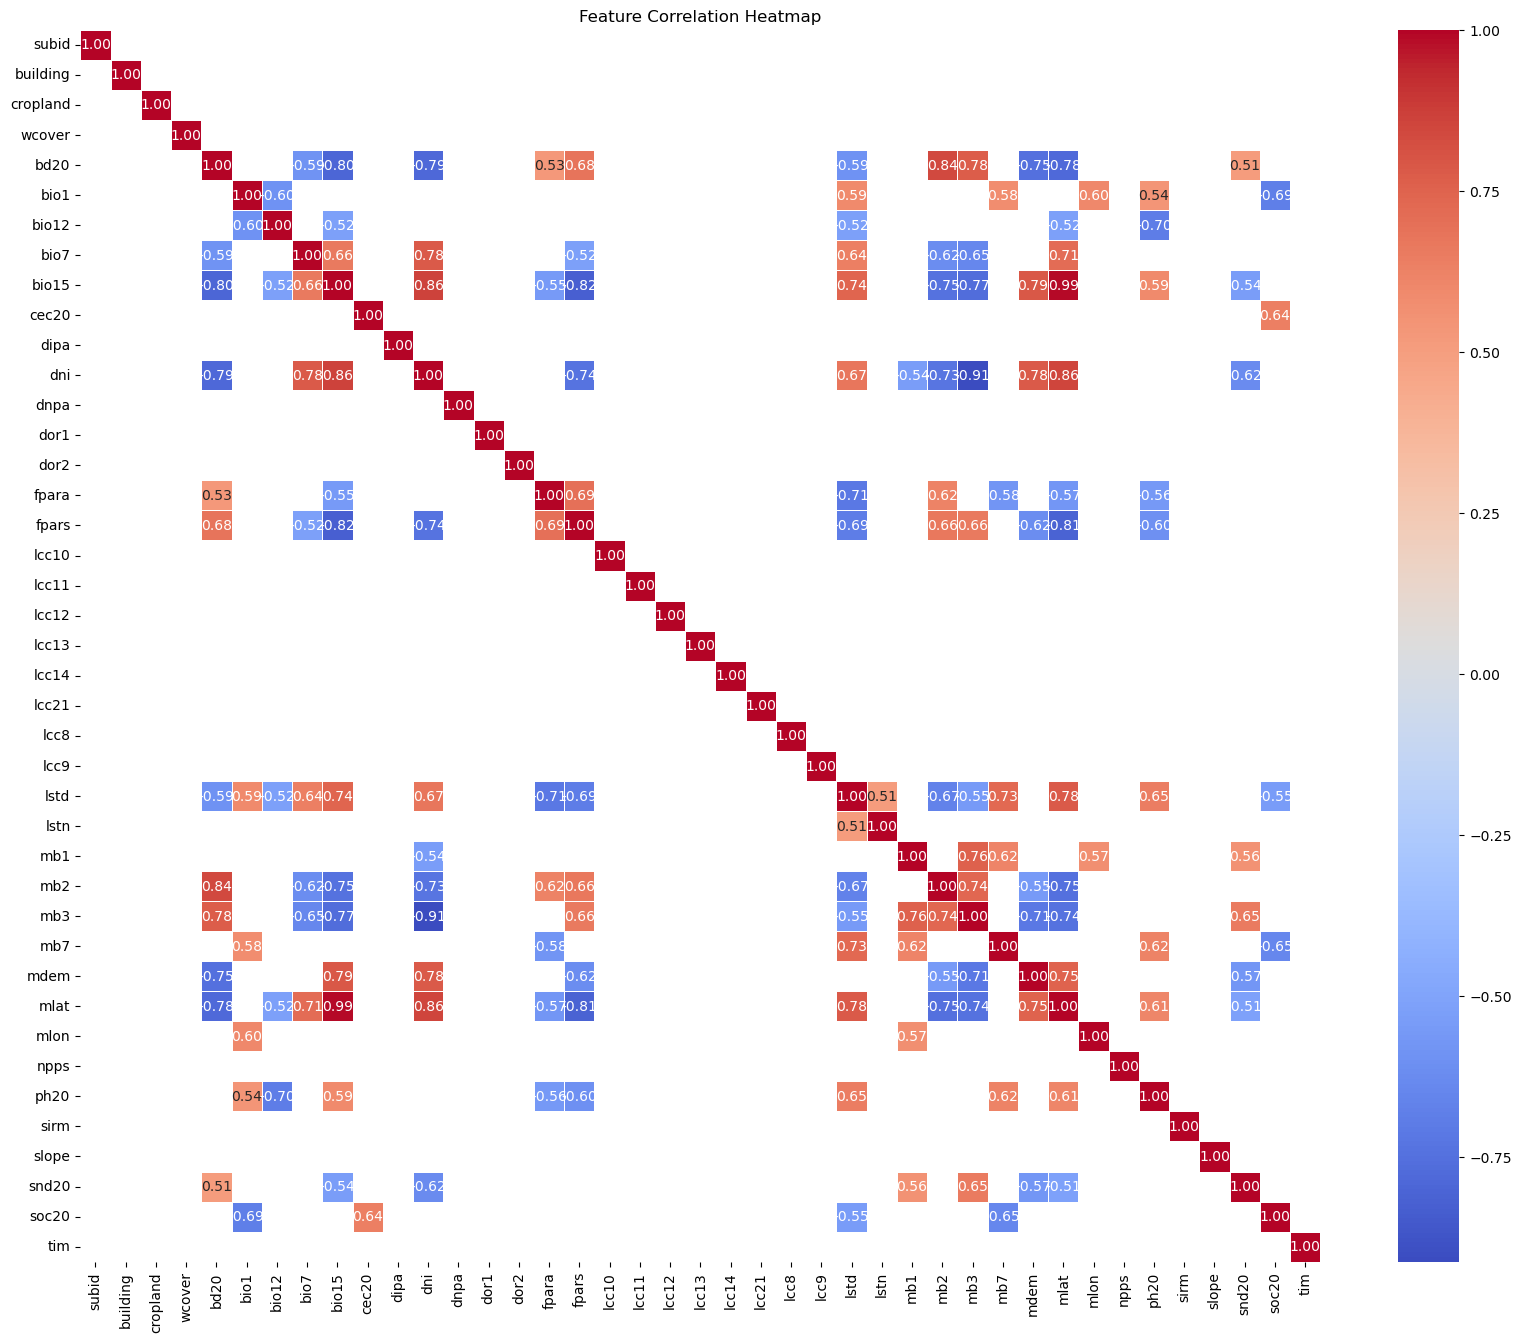

In [29]:

plt.figure(figsize=(20, 16))  
high_corr_features = train_corrM[abs(train_corrM) > 0.5] 
sns.heatmap(high_corr_features, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Defining Training and validation sets


#### Full training data

In [30]:
# Defining features for the model and the targets. pred is from comparing training dataset vs test

features_ = train_ds_copy.drop(pred, axis=1)
target_ = train_ds_copy[pred]

print(features_.columns, target_.columns)

Index(['subid', 'bd20', 'bio1', 'bio12', 'bio7', 'bio15', 'cec20', 'dipa',
       'dni', 'dnpa', 'dor1', 'dor2', 'fpara', 'fpars', 'lcc10', 'lcc11',
       'lcc12', 'lcc13', 'lcc14', 'lcc21', 'lcc8', 'lcc9', 'lstd', 'lstn',
       'mb1', 'mb2', 'mb3', 'mb7', 'mdem', 'mlat', 'mlon', 'npps', 'ph20',
       'sirm', 'slope', 'snd20', 'soc20', 'tim'],
      dtype='object') Index(['building', 'cropland', 'wcover'], dtype='object')


In [31]:
features_.head() #view data before scaling

,subid,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnpa,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
0,1548937,1.4900,262,1006,58,128,9.75,165.716812,946.728027,0.000000,...,199,7.388742,-4.781606,853.451416,6.100,0.717054,0.729217,66.75,12.25,8.079082
1,1548936,1.2925,257,1118,70,162,7.50,153.844894,1184.870972,9.617692,...,362,8.691314,-5.771476,933.074402,5.575,0.717198,1.086981,51.50,14.25,9.549431
2,1548935,1.3050,265,930,66,154,8.50,45.458771,1081.140015,36.834934,...,288,8.519824,-2.809363,1186.817627,5.850,0.717171,1.159993,47.00,14.50,10.523131
3,1548934,1.3275,263,875,67,156,8.75,16.342047,1065.068970,17.307875,...,320,8.638784,-3.050085,910.979309,5.950,0.718244,2.471163,62.75,12.75,9.305363
4,1548933,1.4200,260,1073,60,146,9.00,219.401459,1085.887939,2.015564,...,265,7.994523,-6.045455,802.602661,5.800,0.716653,0.259416,55.00,13.25,15.732859


In [32]:
print(features_.shape)
print(test_ds.shape)

(15856, 38)
(35, 38)


In [33]:
features_.set_index("subid", inplace=True)
test_ds.set_index("subid", inplace=True)


In [34]:
test_ds.head(), features_.head()

(           bd20  bio1  bio12  bio7  bio15  cec20        dipa         dni  \
 subid                                                                      
 1548905  1.4075   250   2564    46     61   8.50   61.519306  901.802002   
 1548829  1.6350   261   1378    71     76   6.50  124.008316  830.578003   
 1548811  1.5825   247   1704    46     67  14.00   15.542281  894.497009   
 1548806  1.7350   261   1700    68     76   6.75   43.018166  803.184998   
 1548798  1.5925   259   1724    61     55   6.50   60.299255  922.987000   
 
              dnpa       dor1  ...  mdem      mlat      mlon         npps  \
 subid                         ...                                          
 1548905  31.28598   4.828302  ...   118  4.825554 -7.524098   870.217346   
 1548829   0.00000  16.918924  ...    37  5.458789 -5.011604   839.143616   
 1548811   0.00000  24.839485  ...   220  5.082793 -7.149833   763.726135   
 1548806   0.00000   7.988273  ...    49  5.674226 -4.172613   814.182434 

In [35]:
# Preserve the index and column names
features_index = features_.index
features_columns = features_.columns

# Standardize the feature values (excluding index)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_)

# Convert back to DataFrame with original index and column names
features_scaled = pd.DataFrame(features_scaled, index=features_index, columns=features_columns)

# Standardize test dataset (assuming it has the same columns)
test_ds_scaled = pd.DataFrame(scaler.transform(test_ds), index=test_ds.index, columns=test_ds.columns)



In [37]:
features_scaled.head()

,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnpa,dor1,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
subid,,,,,,,,,,,,,,,,,,,,,
1548937,0.328164,0.470228,-1.067004,-0.598732,-0.137275,0.438461,1.208009,-0.667592,-0.888294,-1.019849,...,-0.515970,-0.170816,0.518238,-0.487949,1.419969,0.050593,-0.484082,1.591626,-0.871119,-1.291541
1548936,-0.880235,-0.289853,-0.625856,0.309678,0.820488,-0.518635,1.006247,0.575858,0.050339,0.613172,...,0.803884,0.711542,-0.141550,-0.237709,-0.107628,0.052762,-0.262242,-0.503919,-0.504402,-0.450363
1548935,-0.803755,0.926277,-1.366355,0.006875,0.595132,-0.093259,-0.835768,0.034232,2.706588,1.923764,...,0.204687,0.595375,1.832819,0.559757,0.692542,0.052358,-0.216969,-1.122277,-0.458562,0.106686
1548934,-0.666089,0.622245,-1.582990,0.082576,0.651471,0.013085,-1.330605,-0.049682,0.800857,-0.100335,...,0.463799,0.675959,1.672368,-0.307150,0.983512,0.068570,0.596051,1.041975,-0.779440,-0.589993
1548933,-0.100130,0.166196,-0.803103,-0.447330,0.369776,0.119429,2.120377,0.059023,-0.691586,-0.032678,...,0.018450,0.239537,-0.324168,-0.647757,0.547057,0.044540,-0.775392,-0.022974,-0.687761,3.087141


In [38]:
# Splitting the dataset into train and validation sets
X_train, X_val,Y_train, Y_val = train_test_split(features_scaled, target_,
                                      random_state=32,
                                      test_size=0.20)

# Check the shape of both sets
X_train.shape, X_val.shape, test_ds.shape

((12684, 37), (3172, 37), (35, 37))

In [39]:
X_train.head() #view data after scaling

,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnpa,dor1,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
subid,,,,,,,,,,,,,,,,,,,,,
1532341,-0.528423,-0.137837,-0.602223,0.309678,0.820488,-0.412291,0.144105,0.490038,0.185244,-1.111507,...,1.006316,0.779802,0.169607,0.208649,-0.253113,0.076386,-0.064370,-0.881805,-0.550241,-0.170092
1548405,1.276528,-0.593886,0.922103,0.309678,-1.545750,-0.093259,-0.147798,-1.264523,-0.888294,-0.135166,...,-1.309502,-1.559231,-0.171467,0.432014,-1.489739,0.145878,-0.010014,0.492324,0.229034,-0.663888
1536949,0.037536,0.318212,-0.381648,-0.523031,0.341607,-0.093259,1.312376,-0.169832,0.191878,-0.235149,...,-0.022037,0.255915,0.037965,-0.175906,0.037858,0.030755,-0.157194,0.183145,-0.137684,0.080687
1535986,1.092973,0.622245,-0.917329,-0.523031,-0.672495,0.013085,1.037673,-1.008970,0.095245,-1.152322,...,-1.301405,-0.637540,0.753128,-0.653458,1.056255,0.061425,0.447485,1.832099,-0.137684,0.632652
1537315,-0.054241,-0.897918,0.638507,-1.582843,-1.066868,-0.199603,-1.608337,-0.545536,-0.570175,-0.267742,...,-0.823666,-1.220259,-0.749094,1.088214,0.110601,0.153165,-0.594566,0.045732,-0.091844,0.093145


### Model creation and training

In [ ]:
label = list(pred)
label

MODEL 1 results

Hyperparameters to consider for sklearn randomforest classifier
1. **DEFAULT HYPERPARAMEETERS**
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)[source]

 **EVALUATION RESULTS for random forest classifier**
For all the features i.e. the dropped columns

building Accuracy: 0.9426229508196722
cropland Accuracy: 0.7831021437578815
wcover Accuracy: 0.5772383354350568

MODEL 2 results
 **EVALUATION RESULTS for xgboost classifier**

building Accuracy: 0.9397856242118537
cropland Accuracy: 0.7704918032786885
wcover Accuracy: 0.5778688524590164

In [40]:
# Create multi-output classifier
base_clf = RandomForestClassifier(random_state=42)
multi_clf = MultiOutputClassifier(base_clf)

# Train model
multi_clf.fit(X_train, Y_train)

# Predict
Y_pred = multi_clf.predict(X_val)

# Evaluate accuracy for each target

for i, label in enumerate(target_.columns):
    print(f"{label} Accuracy: {accuracy_score(Y_val[label], Y_pred[:, i])}")

building Accuracy: 0.9426229508196722
cropland Accuracy: 0.7831021437578815
wcover Accuracy: 0.5772383354350568


#### SECOND MODEL - XGBOOST

In [ ]:
!pip install xgboost 
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()


In [ ]:
# Create multi-output classifier
base_clf_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
multi_clf_xgb = MultiOutputClassifier(base_clf_xgb)

# Train model
multi_clf_xgb.fit(X_train, Y_train)

# Predict
Y_pred = multi_clf_xgb.predict(X_val)

# Evaluate accuracy for each target

for i, label in enumerate(target_.columns):
    print(f"{label} Accuracy: {accuracy_score(Y_val[label], Y_pred[:, i])}")

#### PREDICTION ON TEST DATASET ON FIRST MODEL

In [41]:
test_ds_scaled.head()

,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnpa,dor1,...,mdem,mlat,mlon,npps,ph20,sirm,slope,snd20,soc20,tim
subid,,,,,,,,,,,,,,,,,,,,,
1548905,-0.176610,-1.353967,5.069685,-1.507142,-2.024631,-0.093259,-0.562821,-0.902171,2.165041,-0.712197,...,-1.171848,-1.907113,-1.309745,-0.435257,-1.707967,0.081007,1.601815,1.282448,1.191668,-0.668472
1548829,1.215343,0.318212,0.398239,0.385379,-1.602088,-0.944011,0.499176,-1.274063,-0.888294,0.517242,...,-1.827727,-1.478161,0.364935,-0.532915,-2.217166,0.156256,-0.633750,1.454214,-0.733600,-1.396267
1548811,0.894123,-1.810016,1.682296,-1.507142,-1.855614,2.246309,-1.344197,-0.940313,-0.888294,1.322648,...,-0.345927,-1.732860,-1.060282,-0.769938,-1.489739,0.099223,0.374550,-0.435213,1.145828,-1.562176
1548806,1.827191,0.318212,1.666540,0.158277,-1.602088,-0.837667,-0.877246,-1.417094,-0.888294,-0.390874,...,-1.730560,-1.332225,0.924157,-0.611364,-1.416996,0.155902,-0.339168,0.629737,-0.366883,-1.067126
1548798,0.955308,0.014180,1.761072,-0.371629,-2.193648,-0.944011,-0.583555,-0.791555,-0.888294,-1.073541,...,-1.941088,-2.014560,-0.988275,2.516711,-1.926196,0.044215,-0.453052,2.106925,-0.229363,1.938472


In [44]:
# Make predictions
y_pred = multi_clf.predict(test_ds_scaled)
y_pred_proba = multi_clf.predict_proba(test_ds_scaled)

# Convert predicted classes to a DataFrame
y_pred_df = pd.DataFrame(y_pred, index=test_ds.index, columns=['building_pred', 'cropland_pred', 'wcover_pred'])

# Convert probabilities to a DataFrame
y_pred_proba_df = pd.DataFrame({
    'building_prob': y_pred_proba[0][:, 1],  # Prob of "Yes" for Buildings
    'cropland_prob': y_pred_proba[1][:, 1],  # Prob of "Yes" for Cropland
    'wcover_prob': y_pred_proba[2][:, 2]  # Prob of ">60%" for Wcover
}, index=test_ds.index)

# Print results
print(y_pred_df.head())
print(y_pred_proba_df.head())



         building_pred  cropland_pred  wcover_pred
subid                                             
1548905              0              0            2
1548829              0              0            2
1548811              0              0            2
1548806              0              1            2
1548798              0              1            2
         building_prob  cropland_prob  wcover_prob
subid                                             
1548905           0.15           0.44         0.81
1548829           0.09           0.40         0.70
1548811           0.06           0.15         0.72
1548806           0.03           0.61         0.78
1548798           0.09           0.67         0.67


In [45]:
y_pred_proba_df.to_csv("predicted_probabilities.csv", index=True)


#### HYPERPARAMETERS TUNING GRID SEARCH
-Seeking best hyperparameters

In [ ]:
# Define Hyperparameter Grid
base_clf_cv = MultiOutputClassifier(RandomForestClassifier())
param_grid = {
    "estimator__n_estimators": list(range(100, 301, 100)),  # 100 to 300 in steps of 100
    "estimator__criterion": ["gini", "entropy", "log_loss"],  # Different split criteria
    "estimator__max_depth": [None] + list(range(10, 31, 10)),  # None, 10, 20, 30
    "estimator__min_samples_split": list(range(2, 7, 2)),  # 2 to 7, step 2
    "estimator__min_samples_leaf": list(range(1, 6)),  # 1 to 5
    "estimator__min_weight_fraction_leaf": np.linspace(0.0, 0.5, 3).tolist(),  # 0.0, 0.25, 0.5
    "estimator__max_features": ["auto", "sqrt", "log2"],  
    "estimator__max_leaf_nodes": [None] + list(range(10, 101, 30)),  # None, 10, 40, 70, 100
    "estimator__min_impurity_decrease": np.linspace(0.0, 0.2, 3).tolist(),  # 0.0, 0.1, 0.2
    "estimator__bootstrap": [True, False],  # Bootstrap sampling
    "estimator__oob_score": [True, False],  # Out-of-bag score (only used if bootstrap=True)
    "estimator__n_jobs": [-1],  # Use all available cores
  
}



# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=base_clf_cv,
    param_grid=param_grid,
    cv=5,          # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1,     # Use all available cores
    verbose=2      # Print progress
)


# Run Grid Search (Make sure X_train, y_train are defined)
grid_search.fit(X_train, Y_train)

# Print best parameters & best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)